In [1]:
!pip install torch torchvision
!pip install transformers

In [2]:
import pandas as pd
import numpy as np



In [3]:
df_train = pd.read_csv(r'C:\Users\lande\Downloads\comparg_train (1).tsv', sep='\t', encoding='utf-8')
df_test = pd.read_csv(r'C:\Users\lande\Downloads\comparg_test (1).tsv', sep='\t', encoding='utf-8')

In [4]:
# korrigiere labels
df_train['labels'] = df_train['labels'].replace({2: 1})
df_train['labels'] = df_train['labels'].replace({3: 2})

df_test['labels'] = df_test['labels'].replace({2: 1})
df_test['labels'] = df_test['labels'].replace({3: 2})




In [5]:
import re

def mask_objects(row):
    row["text"] = re.sub(re.escape(row["object_0"]), "[FIRST_ENTITY]", row["answer"], flags=re.IGNORECASE)
    row["text"] = re.sub(re.escape(row["object_1"]), "[SECOND_ENTITY]", row["text"], flags=re.IGNORECASE)
    return row


def transform_data(df):
  df = df.apply(mask_objects,axis=1)
  return df

df_train = transform_data(df_train).sample(frac=1, random_state=42).reset_index(drop=True)
df_test = transform_data(df_test)

In [ ]:
print(df_train.head())

          object_0 object_1  \
0  Hewlett-Packard     Dell   
1            Apple   Google   
2            pizza  sausage   
3            Apple    Intel   
4           Oracle    MySQL   

                                              answer  labels  \
0  Nokia towered over its rivals in ways that Toy...       0   
1  For better or worse, a majority of people stil...       0   
2  Moral disputes are like disputes about whether...       1   
3  Notice that Apple no longer develop its own pr...       0   
4                           Would Oracle Harm MySQL?       0   

                                                text  
0  Nokia towered over its rivals in ways that Toy...  
1  For better or worse, a majority of people stil...  
2  Moral disputes are like disputes about whether...  
3  Notice that [FIRST_ENTITY] no longer develop i...  
4         Would [FIRST_ENTITY] Harm [SECOND_ENTITY]?  


<Axes: xlabel='labels'>

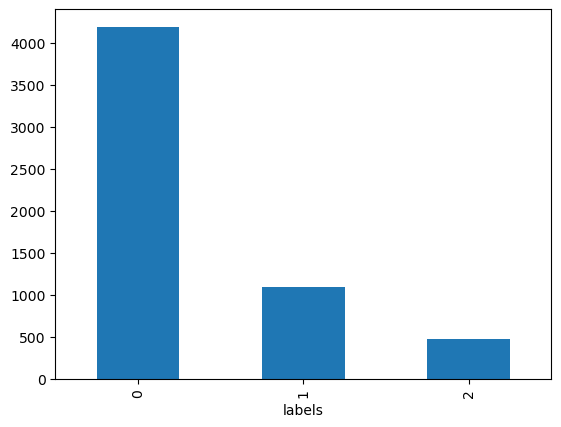

In [ ]:
df_train['labels'].value_counts().sort_index().plot(kind='bar')

In [6]:
from transformers import RobertaConfig, AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import numpy as np

In [7]:
train_texts = df_train['text'].tolist()
train_labels = df_train['labels'].tolist()
test_texts = df_test['text'].tolist()
test_labels = df_test['labels'].tolist()

In [1]:
# print(train_texts)
# print(train_labels)
# print(test_texts)
# print(test_labels)

In [8]:
tokenizer = AutoTokenizer.from_pretrained('roberta-large')

In [9]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]


        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }





In [10]:
max_length = 64
train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_length)
test_dataset = CustomDataset(test_texts, test_labels, tokenizer, max_length)

In [11]:
from transformers import set_seed, AutoModelForSequenceClassification
set_seed(42)
model = AutoModelForSequenceClassification.from_pretrained("roberta-large", num_labels=3)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

training_args = TrainingArguments(
    overwrite_output_dir=True,
    num_train_epochs=5,
    fp16=False,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,
    learning_rate=3e-5,
    output_dir=r"C:\Users\lande\Downloads\checkpoints",


    )
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [13]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    data_collator = data_collator,
    tokenizer = tokenizer,
)

In [14]:
trainer.train()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.511500
1000,0.391600
1500,0.272800


TrainOutput(global_step=1800, training_loss=0.36387203640407983, metrics={'train_runtime': 240.89, 'train_samples_per_second': 119.536, 'train_steps_per_second': 7.472, 'total_flos': 4520894406455064.0, 'train_loss': 0.36387203640407983, 'epoch': 5.0})

In [17]:
outputs = trainer.predict(test_dataset)

In [16]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

predictions = outputs.predictions.argmax(-1)
target_names = ["neutral", "objekt1", "objekt2"]
print(classification_report(y_true=test_dataset.labels, y_pred=predictions, target_names=target_names))
print(f"F1-micro: {f1_score(y_true=test_dataset.labels, y_pred=predictions, average='micro')}")


              precision    recall  f1-score   support

     neutral       0.95      0.94      0.94      1048
     objekt1       0.85      0.87      0.86       273
     objekt2       0.68      0.71      0.70       119

    accuracy                           0.91      1440
   macro avg       0.83      0.84      0.83      1440
weighted avg       0.91      0.91      0.91      1440

F1-micro: 0.9076388888888889


In [ ]:
output_model_dir = r"C:\Users\lande\Downloads\roberta_5epoch"
trainer.save_model(output_model_dir)

In [18]:
df_test['preds'] = predictions
df_test.to_csv(r"C:\Users\lande\Downloads\roberta_5epoch_preds.tsv", sep="\t", index=False)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(r"C:\Users\lande\Downloads\roberta_5epoch")
tokenizer = AutoTokenizer.from_pretrained(r"C:\Users\lande\Downloads\roberta_5epoch")


In [ ]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    data_collator = data_collator,
    tokenizer = tokenizer,
)

In [ ]:
outputs = trainer.predict(test_dataset)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

predictions = outputs.predictions.argmax(-1)
target_names = ["neutral", "objekt1", "objekt2"]
print(classification_report(y_true=test_dataset.labels, y_pred=predictions, target_names=target_names))
print(f"F1-micro: {f1_score(y_true=test_dataset.labels, y_pred=predictions, average='micro')}")

              precision    recall  f1-score   support

     neutral       0.95      0.94      0.94      1048
     objekt1       0.85      0.87      0.86       273
     objekt2       0.68      0.71      0.70       119

    accuracy                           0.91      1440
   macro avg       0.83      0.84      0.83      1440
weighted avg       0.91      0.91      0.91      1440

F1-micro: 0.9076388888888889


In [ ]:
df_test['preds'] = predictions
df_test.to_csv(r"C:\Users\lande\Downloads\roberta_5epoch_preds.tsv", sep="\t", index=False)